In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import initialize_weights, epoch_time
from train_eval import train, evaluate
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from tensorboardX import SummaryWriter
import os

import Transformer
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

seed = 777
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

de_field = Field(tokenize = tokenize_de, init_token = '<sos>', eos_token = '<eos>', lower = True, batch_first = True)
en_field = Field(tokenize = tokenize_en, init_token = '<sos>', eos_token = '<eos>', lower = True, batch_first = True)

data_train, data_val, data_test = Multi30k.splits(
    exts = ('.de', '.en'), fields = (de_field, en_field))

de_field.build_vocab(data_train, min_freq = 2)
en_field.build_vocab(data_train, min_freq = 2)

device = torch.device('cuda')
batch_size = 64

train_loader, val_loader, test_loader = BucketIterator.splits(
    (data_train, data_val, data_test),batch_size = batch_size, device = device)

src_vocab_size = len(de_field.vocab)
trg_vocab_size = len(en_field.vocab)

src_pad_idx = de_field.vocab.stoi[de_field.pad_token]
trg_pad_idx = en_field.vocab.stoi[en_field.pad_token]

In [2]:
print(src_vocab_size)
print(trg_vocab_size)

7854
5893


In [3]:
batch = next(iter(train_loader))
src, trg = batch.src, batch.trg
print(src[2])
print(trg[2])
src_sen = [de_field.vocab.itos[i] for i in src[2]]
trg_sen = [en_field.vocab.itos[i] for i in trg[2]]
print(src_sen)
print(trg_sen)

tensor([   2,    5,  116, 2415,  264,   22,   14,   16, 2557,    9,   17,    8,
         555, 2418,   61,    4,    3,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1], device='cuda:0')
tensor([   2,    4, 1131,   12,  515,   17, 5879,   49,    4,   14,   22,   86,
        1955,    5,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1], device='cuda:0')
['<sos>', 'ein', 'paar', 'stiefel', 'werden', 'von', 'einer', 'frau', 'getragen', ',', 'die', 'eine', 'orange', 'strumpfhose', 'trägt', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<sos>', 'a', 'pair', 'of', 'boots', 'are', 'worn', 'by', 'a', 'woman', 'wearing', 'orange', 'tights', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [4]:
dropout = 0
Seq2Seq_transformer = Transformer.Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, dropout = dropout, n_layers = 3, forward_expansion = 2, device = device).to(device)
Seq2Seq_transformer.load_state_dict(torch.load('./ckpt/Transformer.pt'))
Seq2Seq_transformer.eval()

Transformer(
  (encoder): Encoder(
    (input_Embedding): Embedding(7854, 256)
    (positional_Embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): SelfAttention(
          (V): Linear(in_features=256, out_features=256, bias=False)
          (K): Linear(in_features=256, out_features=256, bias=False)
          (Q): Linear(in_features=256, out_features=256, bias=False)
          (fc_out): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout): Dropout(p=0, inplace=False)
      )
      (1): TransformerBlock(
        (attention): SelfAttention(
          (V): Linear(in_f

In [5]:
def translate(sentence, src_field, trg_field, model, device, max_len = 50):
    model.eval()
    if isinstance(sentence, str):
        tokens = [tok.text for tok in spacy_de(sentence)]
    else:
        tokens = [tok.lower() for tok in sentence]
    
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]] #[2] - > sos token....
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device) #first : (batch_size, len(trg_idxes))
        trg_mask = model.make_trg_mask(trg_tensor) #trg mask : (batch_size, 1, trg_idxes, trg_idxes)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, src_mask, trg_mask) #output : (batch_size, len(trg_index), trg_vocab_size)
        
        pred_token = output.argmax(2)[:,-1].item()#last value
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [31]:
import matplotlib.pyplot as plt

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 2, n_cols = 4):
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize = (15, 25))
    
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        attention_np = attention.squeeze(0)[i].cpu().numpy()
        ax.matshow(attention_np, cmap = 'bone')
        
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] +['<eos>'], rotation = 45)
        ax.set_yticklabels([''] + translation)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    plt.show()
    plt.close()

In [35]:
src_sample = vars(data_train.examples[8])['src']
trg_sample = vars(data_train.examples[8])['trg']
print(src_sample)
print(trg_sample)

['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [36]:
translation, attention = translate(src_sample, de_field, en_field, Seq2Seq_transformer, 'cuda')
print(translation)

['a', 'woman', 'in', 'a', 'red', 'outfit', 'is', 'walking', 'down', 'the', 'street', '.', '<eos>']


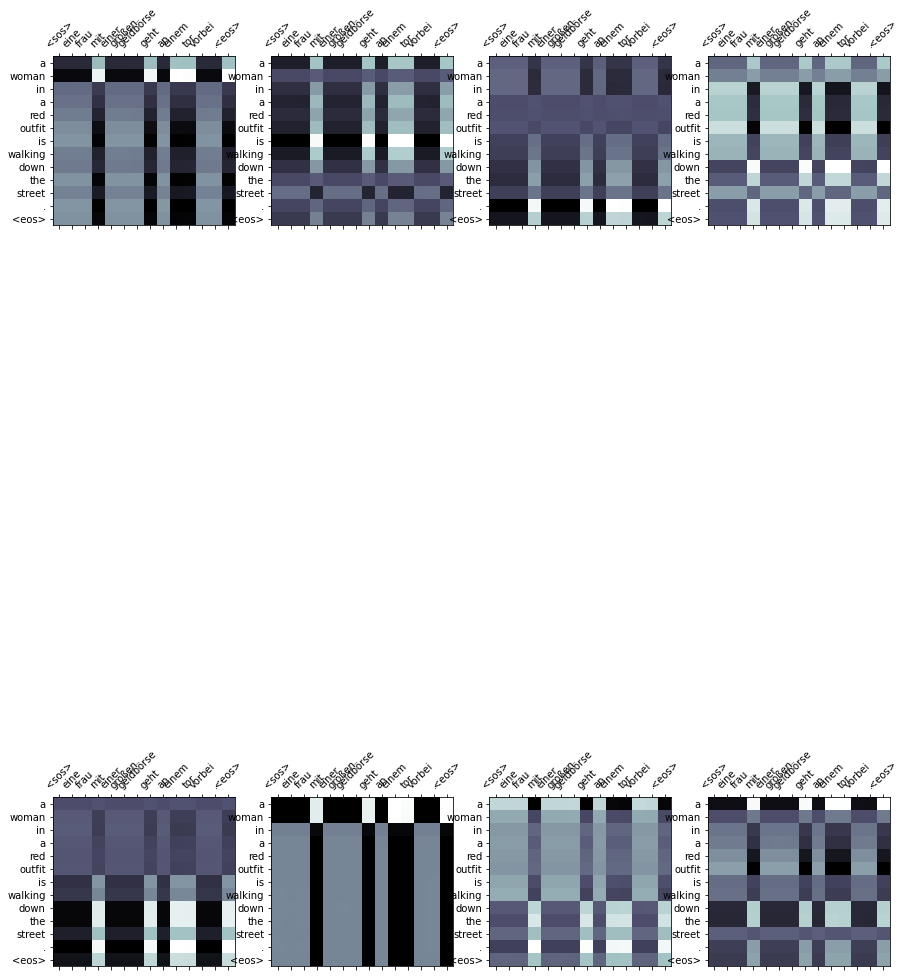

In [37]:
display_attention(src_sample, translation, attention)